In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib

plt.style.use("ggplot")
plt.rcParams["font.family"] = "sans-serif"
sns.set_palette("dark")
sns.set_context("talk")

import numpy as np

from IPython.display import HTML, display, SVG

import pydot
from pydrake.all import (AddMultibodyPlantSceneGraph, DiagramBuilder, BasicVector,
                        Parser, Saturation, Simulator, PlanarSceneGraphVisualizer, 
                        LinearQuadraticRegulator, AbstractValue, MeshcatVisualizer, 
                        StartMeshcat, WrapToSystem, SceneGraph, DiscreteTimeLinearQuadraticRegulator,
                        JacobianWrtVariable, eq, SnoptSolver)    

from pydrake.systems.primitives import LogVectorOutput, ConstantVectorSource
from pydrake.multibody.inverse_kinematics import PositionConstraint, AddUnitQuaternionConstraintOnPlant


from pydrake.multibody.plant import ContactResults
from pydrake.autodiffutils import AutoDiffXd, InitializeAutoDiff, ExtractGradient, ExtractValue
from pydrake.math import RollPitchYaw_, RotationMatrix_, RigidTransform_
from underactuated.meshcat_cpp_utils import MeshcatSliders, MeshcatJointSliders
from Custom_LeafSystems import *

from tqdm import tqdm as tqdm

from Linearize import getGradients

from pydrake.solvers.mathematicalprogram import MathematicalProgram, Solve

from datetime import datetime


Using matplotlib backend: TkAgg


In [2]:
# Start the visualizer (run this cell only once, each instance consumes a port)
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [3]:
time_step = 1/1000.
builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=time_step)
body = Parser(plant).AddModelFromFile("Double_Leg/Double_Leg_Collisions.urdf")
plant.Finalize()

meshcat.Delete()
vis = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
context = plant.CreateDefaultContext()

num_pos = plant.num_positions()
num_vel = plant.num_velocities()
num_act = plant.num_actuators()
num_disc_states = context.num_total_states() - context.num_continuous_states()
fb_num_pos = 7
fb_num_vel = 6
n = 3

x0 = np.zeros(num_disc_states)
x0[0], x0[6] = 1, 0.4

plant.SetPositionsAndVelocities(context, x0)

CoM_0 = plant.CalcCenterOfMassPositionInWorld(context)

plant.get_actuation_input_port().FixValue(context, np.zeros(num_act))

# display(SVG(pydot.graph_from_dot_data(plant.GetTopologyGraphvizString())[0].create_svg()))

foot_L = ["collision_dummy_L_BR", "collision_dummy_L_BL", "collision_dummy_L_FR", "collision_dummy_L_FL"]
foot_R = ["collision_dummy_R_BR", "collision_dummy_R_BL", "collision_dummy_R_FR", "collision_dummy_R_FL"]
feet = ["foot_L", "foot_R"]

num_contact = len(foot_L) + len(foot_R)

def sethome(plant, context, ad=1.):

    shaft_roll = 0.3
    hip_pitch = 0.3
    knee_pitch = 0.6
    foot_pitch = 0.3

    plant.GetJointByName("shaft_roll").set_angle(context, shaft_roll)
    plant.GetJointByName("Hip_Pitch_R").set_angle(context, hip_pitch)
    plant.GetJointByName("Hip_Pitch_L").set_angle(context, hip_pitch)
    plant.GetJointByName("knee_R").set_angle(context, -knee_pitch)
    plant.GetJointByName("knee_L").set_angle(context, -knee_pitch)
    plant.GetJointByName("foot_leg_pitch_R").set_angle(context, foot_pitch)
    plant.GetJointByName("foot_leg_pitch_L").set_angle(context, -foot_pitch)

    foot_pos = plant.GetBodyByName("collision_dummy_L_C").EvalPoseInWorld(context).GetAsMatrix34()[:, -1].reshape(3)
    body_pos = plant.GetBodyByName("base_link").EvalPoseInWorld(context).GetAsMatrix34()[:, -1].reshape(3)

    # print(dir(body_pos), body_pos, foot_pos)
    # print(body_pos, body_pos.GetAsMatrix34())

    body_pos[2] = body_pos[2] - foot_pos[2] + 0.001 # Add radius of collision sphere
    body_pos[1] = -foot_pos[1]

    if np.array([ad]).dtype == float:
        transform = RigidTransform_[float](body_pos)
    else:
        transform = RigidTransform_[AutoDiffXd](body_pos)

    plant.SetFreeBodyPose(context, plant.GetBodyByName("base_link"), transform)


sethome(plant, context)

x0 = plant.GetPositionsAndVelocities(context)

# print(plant.GetBodyByName(foot_L).EvalPoseInWorld(context))
# display(SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString(max_depth=2))[0].create_svg()))

# diagram = builder.Build()

# def PoseOptimization():
#     context_diagram = diagram.CreateDefaultContext()
#     plant_context_from_diagram = diagram.GetSubsystemContext(plant, context_diagram)
#     plant_context_from_diagram.get_mutable_discrete_state_vector().SetFromVector(x0)

#     sliders = MeshcatJointSliders(meshcat, plant, context_diagram)
#     sliders.Run(vis, context_diagram)
#     meshcat.DeleteAddedControls()
#     meshcat.Delete()

# PoseOptimization()


In [4]:

# Pose optimization

plant_f = plant
context_f = plant_f.CreateDefaultContext()

plant_ad = plant.ToAutoDiffXd()
context_ad = plant_ad.CreateDefaultContext()

plant_f.SetPositionsAndVelocities(context_f, x0)
plant_ad.SetPositionsAndVelocities(context_ad, InitializeAutoDiff(x0))

B = plant.MakeActuationMatrix()

def makePosConstraint(plant, context):
    # Position constraint feet
    
    p_AQ_lower = np.array([-np.inf, -np.inf, 0.001])
    p_AQ_upper = np.array([np.inf, np.inf, 0.001])
    p_BQ = np.zeros(3)

    frame_world = plant.world_frame()
    constraints = []

    for point in foot_L:
        frame_foot = plant.GetFrameByName(point)

        pos_constraint = PositionConstraint(plant=plant,
                            frameA=frame_world,
                            p_AQ_lower=p_AQ_lower,
                            p_AQ_upper=p_AQ_upper,
                            frameB=frame_foot,
                            p_BQ=p_BQ,
                            plant_context=context
                            )

        constraints.append(pos_constraint)

    for point in foot_R:
        frame_foot = plant.GetFrameByName(point)

        pos_constraint = PositionConstraint(plant=plant,
                            frameA=frame_world,
                            p_AQ_lower=p_AQ_lower,
                            p_AQ_upper=p_AQ_upper,
                            frameB=frame_foot,
                            p_BQ=p_BQ,
                            plant_context=context
                            )

        constraints.append(pos_constraint)

    return constraints

pos_constraint = makePosConstraint(plant_ad, context_ad)

In [5]:
def get_foot_Jacobian(var):

    if var.dtype == float:
        plant = plant_f
        context = context_f
        p_BoBi_B = np.zeros(3)
    else:
        plant = plant_ad
        context = context_ad 
        p_BoBi_B = InitializeAutoDiff(np.zeros(3))

    frame_world = plant.world_frame()

    for index, point in enumerate(foot_L):
        
        frame_foot = plant.GetFrameByName(point)

        Jc_trans = plant.CalcJacobianTranslationalVelocity(
                context,
                JacobianWrtVariable(1),
                frame_foot,
                p_BoBi_B,
                frame_world,
                frame_world
                )

        if index == 0:
            Jc = Jc_trans
        else:
            Jc = np.vstack((Jc, Jc_trans))

    for point in foot_R:
        
        frame_foot = plant.GetFrameByName(point)

        Jc_trans = plant.CalcJacobianTranslationalVelocity(
                context,
                JacobianWrtVariable(1),
                frame_foot,
                p_BoBi_B,
                frame_world,
                frame_world
                )

        Jc = np.vstack((Jc, Jc_trans))

    return Jc


def calcUnactuatedDynamics(vars):

    split_at = [num_act, num_act + num_pos]
    tau, pos, lambda_c = np.split(vars, split_at)
    
    if tau.dtype == float:
        plant = plant_f
        context = context_f
    else:
        plant = plant_ad
        context = context_ad 

    plant.SetPositions(context, pos)
    plant.SetVelocities(context, np.zeros(num_vel))
    plant.get_actuation_input_port().FixValue(context, tau)

    # M, Cv, taug
    taug = plant.CalcGravityGeneralizedForces(context)
    Cv = plant.CalcBiasTerm(context)
    Jc = get_foot_Jacobian(tau)
    
    return taug[:6] + Jc[:, :6].T @ lambda_c - Cv[:6]


def torque_constraint(vars):
    split_at = [num_act, num_act + num_pos]
    tau, pos, lambda_c = np.split(vars, split_at)
    
    if tau.dtype == float:
        plant = plant_f
        context = context_f
    else:
        plant = plant_ad
        context = context_ad 

    plant.SetPositions(context, pos)
    plant.SetVelocities(context, np.zeros(num_vel))
    plant.get_actuation_input_port().FixValue(context, tau)

    # M, Cv, taug
    taug = plant.CalcGravityGeneralizedForces(context)
    Cv = plant.CalcBiasTerm(context)
    Jc = get_foot_Jacobian(tau)

    B_act = B[6:, :]
    
    return tau + np.linalg.inv(B_act) @ (Cv[6:] - taug[6:] - Jc[:, 6:].T @ lambda_c ) 


def CostTorque(tau):
    return tau.dot(tau)


def CostCoM(q):

    if q.dtype == float:
        plant = plant_f
        context = context_f
    else:
        plant = plant_ad
        context = context_ad

    plant.SetPositions(context, q)
    CoM = plant.CalcCenterOfMassPositionInWorld(context)

    CoM_xy = CoM[0:2]
    CoM_z = CoM[2]

    return CoM_xy.dot(CoM_xy) + 1 / (w_CoM*CoM_z)


In [6]:
# Write Mathematical program
prog = MathematicalProgram()

# Define decision variables
pos = prog.NewContinuousVariables(num_pos, "positions")
torques = prog.NewContinuousVariables(num_act, "torques")
lambdas = prog.NewContinuousVariables(num_contact*n, "lambda")

# Bent knee and hip
# knee_constraint = prog.AddConstraint(pos[4 + fb_num_pos] <= -0.3).evaluator().set_description("Knee bend constraint")
# hip_constraint = prog.AddConstraint(pos[3 + fb_num_pos] >= 0.15).evaluator().set_description("Hip bend constraint")
# knee_constraint_L = prog.AddConstraint(pos[9 + fb_num_pos] <= -0.3).evaluator().set_description("Knee bend constraint")
# hip_constraint_L = prog.AddConstraint(pos[8 + fb_num_pos] >= 0.15).evaluator().set_description("Hip bend constraint")

# Symmetric pose Constraints
# prog.AddConstraint(pos[2 + fb_num_pos] == pos[7 + fb_num_pos]).evaluator().set_description("Symmetry in hip roll")
# prog.AddConstraint(pos[3 + fb_num_pos] == pos[8 + fb_num_pos]).evaluator().set_description("Symmetry in hip pitch")
# prog.AddConstraint(pos[4 + fb_num_pos] == pos[9 + fb_num_pos]).evaluator().set_description("Symmetry in knee pitch")
# prog.AddConstraint(pos[5 + fb_num_pos] == pos[10 + fb_num_pos]).evaluator().set_description("Symmetry in foot pitch")
# prog.AddConstraint(pos[6 + fb_num_pos] == pos[11 + fb_num_pos]).evaluator().set_description("Symmetry in foot roll")

unit_quat_eps = 1e-5

# Quaternion unit length constraint
# (prog.AddConstraint(lambda x: [x @ x], [1 - unit_quat_eps], [1 + unit_quat_eps], pos[0:4]).evaluator().set_description("unit quaternion constraint"))

# Unit quaternion constraint
unit_quat = AddUnitQuaternionConstraintOnPlant(plant_ad, pos, prog)

# Limit Inividual parts of quaternion to be between -1 and 1
(prog.AddBoundingBoxConstraint(-1.0, 1.0, pos[0]).evaluator().set_description("quat0 limit constraint"))
(prog.AddBoundingBoxConstraint(-1.0, 1.0, pos[1]).evaluator().set_description("quat1 limit constraint"))
(prog.AddBoundingBoxConstraint(-1.0, 1.0, pos[2]).evaluator().set_description("quat2 limit constraint"))
(prog.AddBoundingBoxConstraint(-1.0, 1.0, pos[3]).evaluator().set_description("quat3 limit constraint"))

# Static coefficient of friction
mu = 1
X = 0.03
Y = 0.02

# Origin points of the foot
O_L = plant.GetBodyByName("collision_dummy_L_C").EvalPoseInWorld(context).translation()
O_R = plant.GetBodyByName("collision_dummy_R_C").EvalPoseInWorld(context).translation()


# CWC constraint
def CWC(foot, Origin, side):
    
    if side == "L":
        offset = 0
    else:
        offset = n*len(foot_L)

    for index, point in enumerate(foot):
    
        # OC_i
        C_i = plant.GetBodyByName(point).EvalPoseInWorld(context).translation()
        OC_i = C_i - Origin

        # Contact wrench cone f = sum(f_i)
        # Contact wrench cone tau = sum(OC_i x f_i)
        if index == 0:
            f = np.array([lambdas[offset + n*index], lambdas[offset + 1 + n*index], lambdas[offset + 2 + n*index]])
            tau = np.cross(OC_i, np.array([lambdas[offset + n*index], lambdas[offset + 1 + n*index], lambdas[offset + 2 + n*index]]))
        else:
            f += np.array([lambdas[offset + n*index], lambdas[offset + 1 + n*index], lambdas[offset + 2 + n*index]])
            tau += np.cross(OC_i, np.array([lambdas[offset + n*index], lambdas[offset + 1 + n*index], lambdas[offset + 2 + n*index]]))

        # Positive normal force 
        prog.AddConstraint(lambdas[offset + 2 + n*index] >= 1e-5)

        # tau = OCxf
        # OCxf = np.cross(OC_i, np.array([lambdas[offset + n*index], lambdas[offset + 1 + n*index], lambdas[offset + 2 + n*index]]))
        # prog.AddConstraint(lambdas[offset + 3 + n*index] == OCxf[0]).evaluator().set_description(f"OCxf 1 {point}")
        # prog.AddConstraint(lambdas[offset + 4 + n*index] == OCxf[1]).evaluator().set_description(f"OCxf 2 {point}")
        # prog.AddConstraint(lambdas[offset + 5 + n*index] == OCxf[2]).evaluator().set_description(f"OCxf 3 {point}")

    return f, tau
    

f_x_L, tau_L = CWC(foot_L, O_L, "L")
f_x_R, tau_R = CWC(foot_R, O_R, "R")

for i in range(3):
    prog.AddConstraint(plant.gravity_field().gravity_vector()[i]*plant.CalcTotalMass(context) + f_x_L[i] + f_x_R[i] == 0).evaluator().set_description("static force eq.")

def CWC_constraint(force, torque, foot):

    # https://scaron.info/publications/icra-2015.html
    # Linear friction cone
    prog.AddConstraint(-force[0] - mu*force[2] <= 0).evaluator().set_description(f"friction cone x pos {foot}")
    prog.AddConstraint(force[0] - mu*force[2] <= 0).evaluator().set_description(f"friction cone x neg {foot}")
    prog.AddConstraint(-force[1] - mu*force[2] <= 0).evaluator().set_description(f"friction cone y pos {foot}")
    prog.AddConstraint(force[1] - mu*force[2] <= 0).evaluator().set_description(f"friction cone y neg {foot}")

    # Center of pressure constraint
    prog.AddConstraint(-Y*force[0] - torque[0] <= 0).evaluator().set_description(f"CoP x pos {foot}")
    prog.AddConstraint(-Y*force[0] + torque[0] <= 0).evaluator().set_description(f"CoP x neg {foot}")
    prog.AddConstraint(-X*force[0] - torque[1] <= 0).evaluator().set_description(f"CoP y pos {foot}")
    prog.AddConstraint(-X*force[0] - torque[1] <= 0).evaluator().set_description(f"CoP y neg {foot}")

    # Now yaw slippage
    prog.AddConstraint(-Y*force[0] - X*force[1] -(X+Y)*mu*force[2] + mu*torque[0] + mu*torque[1] - torque[2] <= 0).evaluator().set_description(f"yaw 1 {foot}")
    prog.AddConstraint(-Y*force[0] + X*force[1] -(X+Y)*mu*force[2] + mu*torque[0] - mu*torque[1] - torque[2] <= 0).evaluator().set_description(f"yaw 2 {foot}")
    prog.AddConstraint(Y*force[0] - X*force[1] -(X+Y)*mu*force[2] - mu*torque[0] + mu*torque[1] - torque[2] <= 0).evaluator().set_description(f"yaw 3 {foot}")
    prog.AddConstraint(Y*force[0] + X*force[1] -(X+Y)*mu*force[2] - mu*torque[0] - mu*torque[1] - torque[2] <= 0).evaluator().set_description(f"yaw 4 {foot}")
    prog.AddConstraint(Y*force[0] + X*force[1] -(X+Y)*mu*force[2] + mu*torque[0] + mu*torque[1] + torque[2] <= 0).evaluator().set_description(f"yaw 5 {foot}")
    prog.AddConstraint(Y*force[0] - X*force[1] -(X+Y)*mu*force[2] + mu*torque[0] - mu*torque[1] + torque[2] <= 0).evaluator().set_description(f"yaw 6 {foot}")
    prog.AddConstraint(-Y*force[0] + X*force[1] -(X+Y)*mu*force[2] - mu*torque[0] + mu*torque[1] + torque[2] <= 0).evaluator().set_description(f"yaw 7 {foot}")
    prog.AddConstraint(-Y*force[0] - X*force[1] -(X+Y)*mu*force[2] - mu*torque[0] - mu*torque[1] + torque[2] <= 0).evaluator().set_description(f"yaw 8 {foot}")


CWC_constraint(f_x_L, tau_L, "foot_L")
CWC_constraint(f_x_R, tau_R, "foot_R")

# Dynamics constraints for unactuated DOFs
vars = np.concatenate((torques, pos, lambdas))
dyn_constraint = prog.AddConstraint(calcUnactuatedDynamics, lb=[-1e-5]*(6), ub=[1e-5]*(6), vars=vars)
dyn_constraint.evaluator().set_description("Dynamics constraint")

# Torque constraint for actuated DOFs
dyn_constraint = prog.AddConstraint(torque_constraint, lb=[-1e-4]*(num_act), ub=[1e-4]*(num_act), vars=vars) 
dyn_constraint.evaluator().set_description("Torque constraint")

# Foot position constraints
for index, constraints in enumerate(pos_constraint):
    prog.AddConstraint(constraints, pos).evaluator().set_description(f"foot position {index}")

w_CoM = 0.1
prog.AddCost(CostTorque, vars=torques)
prog.AddCost(CostCoM, vars=pos)

fc_guess = np.zeros(n)
fc_guess = -plant.gravity_field().gravity_vector() * plant.CalcTotalMass(context) / num_contact
fc_guess = np.tile(fc_guess, num_contact)

tau_guess = np.zeros(num_act)

# Setting initial guess for decision variables
prog.SetInitialGuess(pos, x0[:num_pos])
prog.SetInitialGuess(torques, tau_guess)
prog.SetInitialGuess(lambdas, fc_guess)

# Write solver status to file
path = f"Logs/Double_Leg/{datetime.now().strftime('%Y-%m-%d_%H-%M_SNOPT.out')}"
snopt = SnoptSolver().solver_id()
prog.SetSolverOption(snopt, 'Print file', path)

# Solve optimization problem
result = Solve(prog)

q = result.GetSolution(pos)
tau = result.GetSolution(torques)
fc = result.GetSolution(lambdas)

x0 = np.hstack((q, np.zeros(num_vel)))

# In case of infeasible quaternion constraint to still enable simulation
x0[0:4] = x0[0:4] / (x0[0:4].dot(x0[0:4]))

print(f'Solution found? {result.is_success()}.')

if not result.is_success():
    infeasible = result.GetInfeasibleConstraintNames(prog)
    print(infeasible)

plant.SetPositionsAndVelocities(context, x0)
plant.SetPositions(context, q)

CoM = plant.CalcCenterOfMassPositionInWorld(context)

with open(path, "a") as file:
    file.write("\n")
    np.savetxt(file, q, delimiter=",", header="Array of robot joint angles")
    file.write("\n")
    np.savetxt(file, tau, delimiter=",", header="Array of torques")
    file.write("\n")
    np.savetxt(file, fc, delimiter=",", header="Array of contact forces")
    file.write("\n")
    np.savetxt(file, CoM, delimiter=",", header="CoM location")


Solution found? False.
['Dynamics constraint[0]: -0.000010 <= -0.231693 <= 0.000010', 'Torque constraint[1]: -0.000100 <= 0.218763 <= 0.000100', 'Torque constraint[3]: -0.000100 <= -0.218763 <= 0.000100', 'Torque constraint[4]: -0.000100 <= 0.201165 <= 0.000100', 'Torque constraint[5]: -0.000100 <= 0.201165 <= 0.000100', 'Torque constraint[6]: -0.000100 <= -0.334000 <= 0.000100', 'Torque constraint[8]: -0.000100 <= -0.334000 <= 0.000100', 'Torque constraint[11]: -0.000100 <= -0.436308 <= 0.000100']


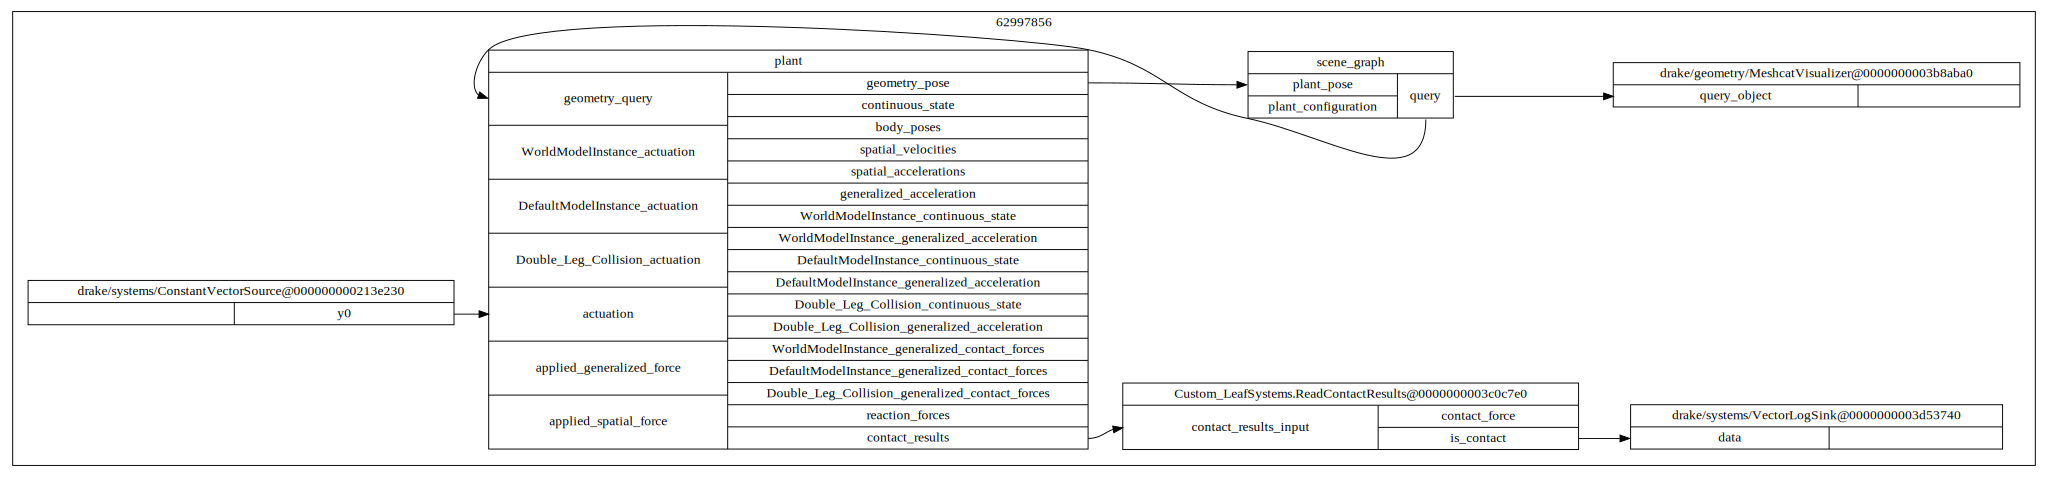

In [7]:
# Wire contact detection logic
generic_input = builder.AddSystem(ConstantVectorSource(np.zeros(num_act)))
contact = builder.AddSystem(ReadContactResults(plant, "foot_L"))

builder.Connect(plant.get_contact_results_output_port(), contact.get_input_port())
builder.Connect(generic_input.get_output_port(), plant.get_actuation_input_port())

logger_is_contact = LogVectorOutput(contact.get_output_port(1), builder, publish_period=1/1000)

diagram = builder.Build()

display(SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString(max_depth=2))[0].create_svg()))

In [8]:
simulator = Simulator(diagram)
sim_context = simulator.get_mutable_context()

sim_context.SetTime(0.)
sim_context.SetDiscreteState(x0)
vis.StartRecording()
simulator.AdvanceTo(10)
vis.StopRecording()
vis.PublishRecording()

meshcat.DeleteAddedControls()

contact_data = logger_is_contact.FindLog(sim_context).data().flatten()
t = np.arange(0, len(contact_data))

fig, ax = plt.subplots()
ax.plot(t, contact_data)

plt.show()

# TODO: Read sources from Shivesh
# TODO: 6 DOF wrench?
# TODO: Apply Zero Moment Point principle to optimization
